In [ ]:
!pip install cachetools --quiet

In [ ]:
!pip install openai --quiet

In [1]:
import pandas as pd
import requests
import xml.etree.ElementTree as Xet
import json 
import matplotlib.pyplot as plt 
import seaborn as sns
import mercury as mr
import numpy as np
from IPython import display
import cachetools.func
import os

from openai import OpenAI

In [2]:
MIN_COMMENTS_LEN = 35
MAX_NUMBER_OF_PAGES = 10
OPEN_AI_KEY = os.environ["OPEN_AI_KEY"]
BGG_SEARCH_URL = "https://www.boardgamegeek.com/xmlapi2/search?type=boardgame&query={query}"
BGG_BASE_URL ="https://www.boardgamegeek.com/xmlapi2"

In [97]:
def _get_poll_result(item: Xet.Element, name):
    results = item.find(f'.//poll[@name="{name}"]')
    options_and_votes = []
    for result in results:
        if name == "suggested_numplayers":
            options_and_votes.append(
                {
                    "option": result.get("numplayers"), 
                    "votes": sum([int(r.get("numvotes")) for r in result if r.get("value")!="Not Recommended"])
                }                
            )
        else:
            for r in result:
                options_and_votes.append(
                    {
                        "option": r.get("value"), 
                        "votes": r.get("numvotes")
                    }                
                )
    options_and_votes = sorted(options_and_votes, key=lambda x: x["votes"], reverse=True)
    return options_and_votes[0]

In [110]:
def get_info(_id, base_url=BGG_BASE_URL):
    info = requests.get(f"{base_url}/thing?id={_id}").content.decode()
    xmlparse = Xet.fromstring(info)
    for item in xmlparse: 
        name = item.find("name").get("value")
        description = item.find("description").text
        image = item.find("image").text
        yearpublished = item.find("yearpublished").get("value")
        minplayers = item.find("minplayers").get("value")
        maxplayers = item.find("maxplayers").get("value")
        best_num_players = _get_poll_result(item, "suggested_numplayers")
        best_players_min_age = _get_poll_result(item, "suggested_playerage")
        best_lang_dep = _get_poll_result(item, "language_dependence")
    return name, description, image, yearpublished, minplayers, maxplayers, best_num_players, best_players_min_age, best_lang_dep

In [111]:
def get_comments(id_array, base_url="https://www.boardgamegeek.com/xmlapi2", verbose=1, max_pages=None):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1        
        if max_comments_per_page < page_size and page_number>1:
            break
        if max_pages is not None and page_number>max_pages:
            print(f"max page number ({max_pages}) reached")
            break
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        
        comments = requests.get(f"{base_url}/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")

    comments_df = pd.DataFrame(comments_array)
    comments_df['rating'] = pd.to_numeric(comments_df['rating'], errors='coerce')
    
    print(f"number of comments collected: {len(comments_df)}")
    return comments_df

In [112]:
def search_boardgame(boardgame_name, raise_if_empty=True):
    response = requests.get(BGG_SEARCH_URL.format(query=boardgame_name))
    response_content = response.content.decode()
    xmlparse = Xet.fromstring(response_content)
    results = [
        {
            'id': i.get("id"),
            'name': i.find("name").get("value"),
            'year': i.find("yearpublished").get("value") if i.find("yearpublished") else 'unknown'
        } for i in xmlparse
    ]
    if raise_if_empty and len(results) == 0:
        raise BggSuggestionException("Empty results, try another string")
    return results

In [113]:
# search_boardgame("Ark nova")

In [114]:
mr.App(
    title='BGG comments summarizer',
    description='Given a BGG game id, this application summarizes "all" the available comments to return positive and negative main aspects',
)

mercury.App

mercury.App

In [115]:
game_name = mr.Text(label="Look for a game by name")

mercury.Text

In [117]:
games_details = [{'id': '-', 'name': '-', 'year': '-'}]
if game_name.value == "text":
    mr.Stop()
else:
    games_details.extend(search_boardgame(game_name.value))

In [118]:
game_selection = mr.Select(
    choices=[f"{g['id']} ### {g['name']} ### {g['year']}" for g in games_details],
    label='Select the resulting game from this list'
)

mercury.Select

In [119]:
game_id = game_selection.value.split("###")[0]

In [120]:
verbose_check = mr.Checkbox(value=False, label='Verbose')

mercury.Checkbox

In [121]:
try:
    _id = int(game_id)    # Unmatched Adventures: Tales to Amaze (2023) = 381297; Ark Nova = 342942
except ValueError:
    if game_id == "- ":
        print(f"Insert a BGG game ID to proceed")
    else: 
        print(f"'{game_id}' is not a valid ID")
    mr.Stop()

In [122]:
name, description, image, yearpublished, minplayers, maxplayers, best_num_players, best_players_min_age, best_lang_dep = get_info(_id)

In [125]:
display.HTML(f"""
<table>
<tbody>
  <tr>
    <td rowspan="5"><img src='{image}' width="300"></td>
    <td colspan="2"><b>{name}</b></td>
  </tr>
  <tr>
    <td>Year</td>
    <td>{yearpublished}</td>
  </tr>
  <tr>
    <td>Players</td>
    <td>{minplayers} - {maxplayers} (Best: {best_num_players['option']})</td>
  </tr>
  <tr>
    <td>Min Age</td>
    <td>{best_players_min_age['option']}</td>
  </tr>
  <tr>
    <td>Lang dep</td>
    <td>{best_lang_dep['option']}</td>
  </tr>
  <tr>
    <td colspan="4">{description}</td>
  </tr>
</tbody>
</table>
""")

In [104]:
print(f"Getting comments for BGG id = {_id} ({name})")
comments_df = get_comments(id_array=[{"id": str(_id)}], max_pages=MAX_NUMBER_OF_PAGES)
if verbose_check.value:
    display.display(comments_df)

Getting comments for BGG id = 381297 (Unmatched Adventures: Tales to Amaze)
page number = 1 (max: 100, len: 1)
page number = 2 (max: 100, len: 1)
page number = 3 (max: 100, len: 1)
page number = 4 (max: 21, len: 1)
number of comments collected: 321


In [67]:
comments_df['value_len'] = comments_df['value'].str.len()

In [68]:
# plt.figure(figsize=(5, 3))
# sns.histplot(data=comments_df, x="value_len")

In [69]:
comments_df = comments_df[comments_df.value_len>MIN_COMMENTS_LEN].reset_index(drop=True)
# comments_df.sort_values(by='value_len')

In [156]:
if verbose_check.value:
    plt.figure(figsize=(8, 3))
    sns.histplot(data=comments_df, x="value_len")

In [72]:
complete_txt = ""
_base = "rating: {rating}\ncomment: {comment}\n###\n"
for _, c in comments_df.to_dict(orient="index").items():
    complete_txt += _base.format(rating=c['rating'], comment=c['value'])

In [177]:
print("")
print("")
print("Comments overview:")
print(complete_txt[:500]+"...")
print("...")
print()

Comments overview:
rating: 7.0
comment: Not as good as normal vs. mode, but still fun, and perfect if you don't like competitive games.
###
rating: 10.0
comment: Fun addition to the Unmatched line, with cooperative play and Mothman!
###
rating: 7.0
comment: A great new way to play Unmatched - cooperatively! That being said though, since there are only two villains at this point, I am starting to lose the drive to play against them time and time again. I am sure more villains and minions are on their way though so ...
...



In [178]:
print(f"Comments stats")
print(f"total chars:    {len(complete_txt)}")
print(f"total words:    {len(complete_txt.split(' '))}")
print(f"total comments: {len(complete_txt.split('###'))-1}")

Comments stats
total chars:    53197
total words:    8877
total comments: 170


In [76]:
client = OpenAI(
    # This is the default and can be omitted
    api_key=OPEN_AI_KEY,
)

In [77]:
message_template = """
Considering the following set of comments, separated by "###" of a given board game, summarize its main positive and negative aspects.
Also, some comments can have a rating that identifies how much that user appreciates the game in subject.
Each comment has the following keywords: 
 - 'rating', 
 - 'comment'.
For each aspect found, also report the number of comments that report it in a JSON structure like this: 
 - "aspect": <the aspect detected>,
 - "positive": <a boolean value reflecting if it is positive or negative>,
 - "number": <how many comments report the same aspect>,

{comments}
"""

In [290]:
@cachetools.func.ttl_cache(maxsize=128, ttl=60 * 60)
def get_response_from_prompt(_id):
    print("making request...")
    
    messages = [{"role": "user", "content": message_template.format(comments=complete_txt[:15000])}]
    
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=messages,
        temperature=0.1
    )
    
    response_str = response.choices[0].message.content
    return response_str


In [292]:
response_str = get_response_from_prompt(_id)
if verbose_check.value:
    print(response_str)

{
  "aspects": [
    {
      "aspect": "Cooperative play",
      "positive": true,
      "number": 20
    },
    {
      "aspect": "Variety of characters",
      "positive": true,
      "number": 10
    },
    {
      "aspect": "Difficulty levels",
      "positive": true,
      "number": 6
    },
    {
      "aspect": "Expansion potential",
      "positive": true,
      "number": 3
    },
    {
      "aspect": "Art and components",
      "positive": true,
      "number": 3
    },
    {
      "aspect": "Game length",
      "positive": true,
      "number": 2
    },
    {
      "aspect": "Theme",
      "positive": true,
      "number": 2
    },
    {
      "aspect": "Replayability",
      "positive": false,
      "number": 1
    },
    {
      "aspect": "Balance",
      "positive": false,
      "number": 1
    }
  ]
}


In [276]:
aspects_df = pd.DataFrame(json.loads(response_str)['aspects'])
aspects_df['positive'] = aspects_df['positive'].map({True: "Positive", False: "Negative"})
if verbose_check.value:
    display.display(aspects_df)

aspect  positive  number
0                    Cooperative gameplay  Positive      20
1                   Variety of characters  Positive      12
2                           Replayability  Positive      10
3                       Difficulty levels  Positive       6
4              Art and components quality  Positive       5
5                Lack of villains/enemies  Negative       3
6                             Game length  Positive       2
7   Integration with other Unmatched sets  Positive       2
8                             AI gameplay  Negative       2
9                            Game balance  Negative       2
10                                  Theme  Positive       1

In [277]:
if verbose_check.value:
    display.display(aspects_df.number.sum())

65

In [278]:
aspects_pos_neg_df = aspects_df.groupby("positive").number.sum().sort_index(ascending=False)  # sorting in this way we always have positive first
if verbose_check.value:
    display.display(aspects_pos_neg_df)

positive
Positive    58
Negative     7
Name: number, dtype: int64

In [282]:
def _create_pos_neg_hist(data, pos_neg, ax, max_font=15, min_font=6):
    color_map = {"Positive": "Greens_r", "Negative": "Reds_r"}
    data_tmp = data[data.positive==pos_neg]    
    aspects_by_num = data_tmp.sort_values("number").aspect.to_list()
    h = sns.histplot(x="positive", hue='aspect', weights='number', multiple='stack', data=data_tmp, shrink=0.2, palette=color_map[pos_neg], ax=ax)
    
    h.get_legend().remove()
    for p, a, f in zip(h.patches, aspects_by_num, np.arange(min_font, max_font, (max_font - min_font)/len(aspects_by_num)).tolist()):    
        h.text(0, p.get_y() + p.get_height()/2.0, a, fontsize=f, ha='center', va='center')

    # h.set(xticklabels=[])
#     h.set(xlabel=None)
#     h.set(yticklabels=[])
#     h.set(ylabel=None)
#     h.tick_params(left=False)
    
    h.axis('off')

    return h

In [286]:
def _create_pie(data, ax):
    rg_colors = sns.color_palette("pastel")[2:4]
    
    def _format(v):
        return f"{aspects_pos_neg_df.index}\n{v:.4f}"
    
    g = ax.pie(data, labels=aspects_pos_neg_df.index, autopct='%.0f%%', colors=rg_colors, explode=[0, 0.1])
    for l, p in zip(g[1], g[2]):
        p.set_text(f"{l.get_text()}\n{p.get_text()}")
        l.set_text("")
    
    return g

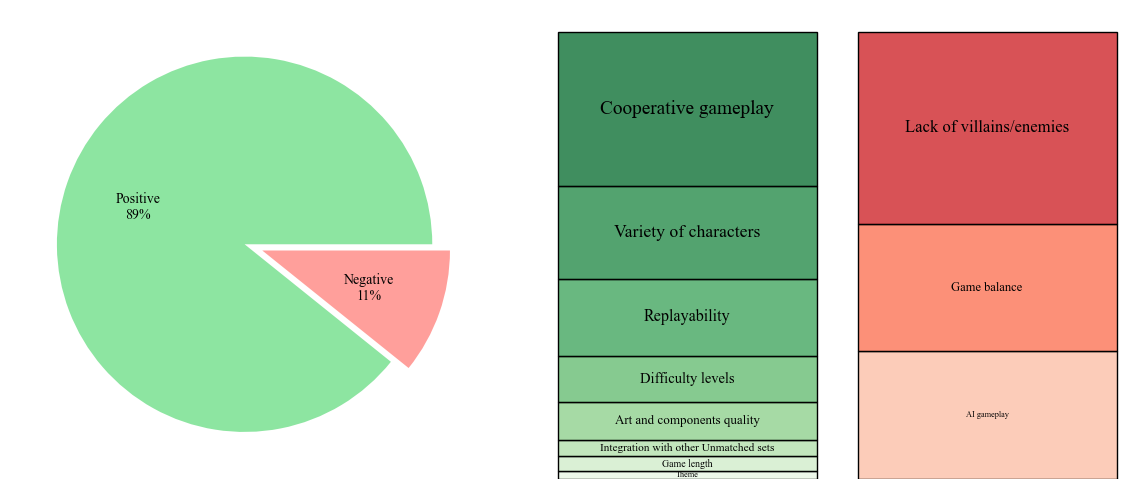

In [287]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 1, 1]})
_create_pie(aspects_pos_neg_df, axes[0])
_create_pos_neg_hist(aspects_df, "Positive", axes[1])
_create_pos_neg_hist(aspects_df, "Negative", axes[2])
plt.tight_layout()

https://bgg-comments-summarizer.runmercury.com/